In [2]:
import pandas as pd
import os
import numpy as np

In [3]:
tradingPairs = {'JBF':'3443','QWF':'2388','HCF':'2498','DBF':'2610','EHF':'1319','IPF':'3035','IIF':'3006','QXF':'2615','PEF':'5425','NAF':'3105'}

In [4]:
stockPath = "../tickData/stocks"
stockFiles = os.listdir(stockPath)
futuresPath = "../tickData/futuresOB"
futuresFiles = os.listdir(futuresPath)
stockFiles.remove('.DS_Store')

In [5]:
stockData = {}
futuresData = {}
for file in stockFiles:
  stockData[file] = os.listdir(stockPath + '/' + file)
for file in futuresFiles:
  futuresData[file] = os.listdir(futuresPath + '/' + file)

In [6]:
stockPriceOneMinute = {}
futuresPriceOneMinute = {}

In [ ]:
for stock in stockData.keys():
  stockPriceOneMinute[stock] = pd.DataFrame()
  for date in stockData[stock]:
    stockTick = pd.read_csv(stockPath + '/' + stock + '/' + date)
    #Data processing
    stockTick = stockTick[['date','time','SP1','BP1']].dropna()
    stockTick = stockTick.loc[stockTick['SP1'] * stockTick['BP1'] != 0]
    stockTick['midQuote'] = np.log(stockTick[['SP1','BP1']].mean(axis=1))
    stockTick['time'] = (stockTick['time'] - stockTick['time'] % 100000) / 100000
    stockPrice = stockTick[['date','time','midQuote']]
    stockPrice_ = stockPrice.groupby(['date','time'])['midQuote'].mean()
    frames = [stockPriceOneMinute[stock], stockPrice_]
    stockPriceOneMinute[stock] = pd.concat(frames)

In [8]:
stockPriceOneMinute

{'2388':                              0
 (2020-07-01, 900.0)   8.124877
 (2020-07-01, 901.0)   8.121594
 (2020-07-01, 902.0)   8.111887
 (2020-07-01, 903.0)   8.099874
 (2020-07-01, 904.0)   8.093469
 ...                        ...
 (2023-06-30, 1320.0)  8.998919
 (2023-06-30, 1321.0)  8.999002
 (2023-06-30, 1322.0)  9.000257
 (2023-06-30, 1323.0)  9.001014
 (2023-06-30, 1324.0)  9.000962
 
 [127668 rows x 1 columns],
 '3105':                               0
 (2020-07-01, 900.0)   10.294299
 (2020-07-01, 901.0)   10.295252
 (2020-07-01, 902.0)   10.295001
 (2020-07-01, 903.0)   10.293296
 (2020-07-01, 904.0)   10.293988
 ...                         ...
 (2023-06-30, 1320.0)   9.706560
 (2023-06-30, 1321.0)   9.706560
 (2023-06-30, 1322.0)   9.706560
 (2023-06-30, 1323.0)   9.706560
 (2023-06-30, 1324.0)   9.707137
 
 [191657 rows x 1 columns],
 '2610':                              0
 (2020-07-01, 900.0)   6.712372
 (2020-07-01, 901.0)   6.714575
 (2020-07-01, 902.0)   6.714777
 (2020-0

In [9]:
for futures in futuresData.keys():
  futuresPriceOneMinute[futures] = pd.DataFrame()
  for date in futuresData[futures]:
    futuresTick = pd.read_csv(futuresPath + '/' + futures + '/' + date)
    #Data processing
    futuresTick = futuresTick[['date','time','askPrice1','bidPrice1']].dropna()
    futuresTick = futuresTick.loc[futuresTick['askPrice1'] * futuresTick['bidPrice1'] != 0]
    futuresTick['midQuote'] = np.log(futuresTick[['askPrice1','bidPrice1']].mean(axis=1))
    futuresTick['time'] = (futuresTick['time'] - futuresTick['time'] % 100000) / 100000
    futuresPrice = futuresTick[['date','time','midQuote']]
    futuresPrice_ = futuresPrice.groupby(['date','time'])['midQuote'].mean()
    frames = [futuresPriceOneMinute[futures], futuresPrice_]
    futuresPriceOneMinute[futures] = pd.concat(frames)

<ipython-input-9-694c084d1dcb>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  futuresTick['midQuote'] = np.log(futuresTick[['askPrice1','bidPrice1']].mean(axis=1))
<ipython-input-9-694c084d1dcb>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  futuresTick['time'] = (futuresTick['time'] - futuresTick['time'] % 100000) / 100000
<ipython-input-9-694c084d1dcb>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead


In [10]:
path_stocks = "/content/drive/MyDrive/Colab Notebooks/Independent project_2023 Summer/stocks"

In [11]:
futuresPriceOneMinute

{'JBF':                               0
 (2020-07-01, 845.0)   10.140534
 (2020-07-01, 846.0)   10.143160
 (2020-07-01, 847.0)   10.145453
 (2020-07-01, 848.0)   10.145943
 (2020-07-01, 849.0)   10.147592
 ...                         ...
 (2023-06-30, 1340.0)  11.991313
 (2023-06-30, 1341.0)  11.990711
 (2023-06-30, 1342.0)  11.990711
 (2023-06-30, 1343.0)  11.990711
 (2023-06-30, 1344.0)  11.990711
 
 [205800 rows x 1 columns],
 'PEF':                              0
 (2020-07-01, 847.0)   8.302142
 (2020-07-01, 848.0)   8.302142
 (2020-07-01, 849.0)   8.302142
 (2020-07-01, 850.0)   8.302142
 (2020-07-01, 851.0)   8.302142
 ...                        ...
 (2023-06-30, 1339.0)  9.179881
 (2023-06-30, 1340.0)  9.179881
 (2023-06-30, 1342.0)  9.179881
 (2023-06-30, 1343.0)  9.179881
 (2023-06-30, 1344.0)  9.180396
 
 [206424 rows x 1 columns],
 'QXF':                              0
 (2022-04-27, 845.0)   9.547991
 (2022-04-27, 846.0)   9.553930
 (2022-04-27, 847.0)   9.549608
 (2022-04-2

In [12]:
spreads = {}
for futures in futuresData.keys():
  spreads[futures] = (stockPriceOneMinute[tradingPairs[futures]] - futuresPriceOneMinute[futures]).dropna()


In [19]:
for name in spreads.keys():
  with open('/content/drive/MyDrive/Colab Notebooks/Independent project_2023 Summer/spreadData/' + name + '_spread.csv', 'w', encoding = 'utf-8-sig') as f:
    spreads[name].to_csv(f)

In [24]:
from matplotlib import pyplot
from pandas.plotting import lag_plot
from pandas.plotting import autocorrelation_plot

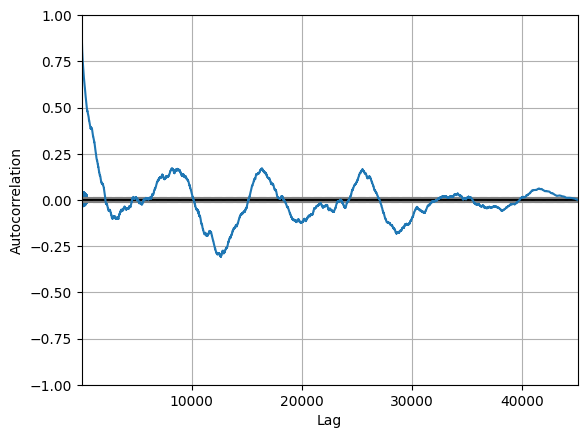

In [25]:
series = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Independent project_2023 Summer/spreadData/DBF_spread.csv', header=0, index_col=0)
lag_plot(series)
autocorrelation_plot(series)
pyplot.show()